# Estudo de caso: previsão de vendas

Nesse estudo vamos fazer uma análise exploratória de dados de vendas, onde cada linha do conjunto contém informações de venda de um determinado item, associadas a ciclos temporais. As colunas de nosso dataset são:

- COD_MATERIAL            Código do produto
- COD_CICLO               Ciclo (variável de tempo)
- DES_CATEGORIA_MATERIAL  Categoria do produto
- DES_MARCA_MATERIAL      Marca do Produto
- FLG_DATA                Indicador de existência ou não de datas comemorativas no ciclo
- FLG_CAMPANHA_MKT_A      Indicador de existência ou não da campanha de marketing A no ciclo
- FLG_CAMPANHA_MKT_B      Indicador de existência ou não da campanha de marketing B no ciclo
- FLG_CAMPANHA_MKT_C      Indicador de existência ou não da campanha de marketing C no ciclo
- FLG_CAMPANHA_MKT_D      Indicador de existência ou não da campanha de marketing D no ciclo
- FLG_CAMPANHA_MKT_E      Indicador de existência ou não da campanha de marketing E no ciclo
- FLG_CAMPANHA_MKT_F      Indicador de existência ou não da campanha de marketing E no ciclo
- PCT_DESCONTO            Percentual de desconto aplicado na venda (0 - 100)
- VL_PRECO                Preço do produto
- QT_VENDA                Quantidade vendida

O objetivo é prever a quantidade vendida de cada item em 3 ciclos específicos: 202016, 202017 e 202101.


Este notebook também contém uma seção de pré-processamento dos dados e diferentes experimentos associados a diferentes abordagens de treinamento de algoritmos de machine learning, na tentativa de encontrar um modelo que apresente uma boa performance quando comparado aos outros. A partir desta exploração construíremos os scripts de pré-processamento, treino e inferência, para possibilitar futuras automações.

## Análise Exploratória

In [1]:
import pandas as pd 
from pandas.plotting import autocorrelation_plot
import numpy as np 
import os
import matplotlib.pyplot as plt 
import seaborn as sns 

from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error

sns.set_style("whitegrid")

/Users/grasiele/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
df = pd.read_csv('output.csv')
df.head()

,COD_MATERIAL,COD_CICLO,DES_CATEGORIA_MATERIAL,DES_MARCA_MATERIAL,FLG_DATA,FLG_CAMPANHA_MKT_A,FLG_CAMPANHA_MKT_B,FLG_CAMPANHA_MKT_C,FLG_CAMPANHA_MKT_D,FLG_CAMPANHA_MKT_E,FLG_CAMPANHA_MKT_F,PCT_DESCONTO,VL_PRECO,QT_VENDA
0,6246,201908,anon_S12,anon_S53,1,0.0,0.0,0.0,0.0,0.0,0.0,NaN,461.4,240.0
1,6246,201915,anon_S12,anon_S53,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,461.4,240.0
2,6306,201916,anon_S12,anon_S53,1,0.0,0.0,0.0,0.0,0.0,0.0,NaN,521.4,240.0
3,6480,201801,anon_S12,anon_S17,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,833.4,528.0
4,6480,201802,anon_S12,anon_S17,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,833.4,564.0


In [3]:
df.shape

(52094, 14)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52094 entries, 0 to 52093
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   COD_MATERIAL            52094 non-null  int64  
 1   COD_CICLO               52094 non-null  int64  
 2   DES_CATEGORIA_MATERIAL  52094 non-null  object 
 3   DES_MARCA_MATERIAL      52094 non-null  object 
 4   FLG_DATA                52094 non-null  int64  
 5   FLG_CAMPANHA_MKT_A      52094 non-null  float64
 6   FLG_CAMPANHA_MKT_B      52094 non-null  float64
 7   FLG_CAMPANHA_MKT_C      52094 non-null  float64
 8   FLG_CAMPANHA_MKT_D      52094 non-null  float64
 9   FLG_CAMPANHA_MKT_E      52094 non-null  float64
 10  FLG_CAMPANHA_MKT_F      52094 non-null  float64
 11  PCT_DESCONTO            16780 non-null  float64
 12  VL_PRECO                52088 non-null  float64
 13  QT_VENDA                48946 non-null  float64
dtypes: float64(9), int64(3), object(2)
mem

In [5]:
df.isna().sum()

COD_MATERIAL                  0
COD_CICLO                     0
DES_CATEGORIA_MATERIAL        0
DES_MARCA_MATERIAL            0
FLG_DATA                      0
FLG_CAMPANHA_MKT_A            0
FLG_CAMPANHA_MKT_B            0
FLG_CAMPANHA_MKT_C            0
FLG_CAMPANHA_MKT_D            0
FLG_CAMPANHA_MKT_E            0
FLG_CAMPANHA_MKT_F            0
PCT_DESCONTO              35314
VL_PRECO                      6
QT_VENDA                   3148
dtype: int64

Vemos que a variável 'PCT_DESCONTO' possui cerca de 68% de dados faltantes. Já nosso target, a variável 'QT_VENDA', possui 3148 dados faltantes. Observe também que as variáveis flag são do tipo float, mas descrevem variáveis de natureza categórica. Por isso, ao analisarmos correlação e propriedades como média, std, e outras, consideraremos somente as variáveis intrinsicamente do tipo numérico.

In [6]:
df[['PCT_DESCONTO', 'VL_PRECO', 'QT_VENDA']].corr()

,PCT_DESCONTO,VL_PRECO,QT_VENDA
PCT_DESCONTO,1.000000,-0.031468,0.006591
VL_PRECO,-0.031468,1.000000,0.100871
QT_VENDA,0.006591,0.100871,1.000000


In [7]:
df[['PCT_DESCONTO', 'VL_PRECO', 'QT_VENDA']].describe().T

,count,mean,std,min,25%,50%,75%,max
PCT_DESCONTO,16780.0,19.461982,77.696194,0.00,15.0,20.0,25.035,10000.00
VL_PRECO,52088.0,544.998243,250.925173,234.06,389.4,461.4,593.400,5539.62
QT_VENDA,48946.0,34004.046275,98123.669055,235.00,810.0,5880.0,29964.000,4047372.00


Pelas descritiva acima, podemos ver que a variável 'pct_desconto' possui outliers. Mas não vamos nos preocupar com essa questão, pois no pré processamento ela será descartada por conter muitos valores faltantes. Vamos agora analisar a distribuição das demais variáveis.

In [8]:
df['DES_CATEGORIA_MATERIAL'].value_counts()

anon_S5     14053
anon_S2     12870
anon_S12    12828
anon_S11     7018
anon_S18     3120
anon_S30     2205
Name: DES_CATEGORIA_MATERIAL, dtype: int64

In [9]:
df['DES_MARCA_MATERIAL'].value_counts()

anon_S8     10302
anon_S24     7361
anon_S23     3649
anon_S22     3513
anon_S20     3333
            ...  
anon_S92        1
anon_S80        1
anon_S87        1
anon_S82        1
anon_S84        1
Name: DES_MARCA_MATERIAL, Length: 85, dtype: int64

Vamos que esta última feature possui uma cardinalidade alta. Vamos, por agora, considerar apenas os 10 valores mais frequentes, e agrupar os demais em uma única categoria chamada 'other'.

In [10]:
counts = df['DES_MARCA_MATERIAL'].value_counts()
to_group = counts[counts < 1525].index.tolist()
df['DES_MARCA_MATERIAL'] = df['DES_MARCA_MATERIAL'].replace(to_group, 'Other')

In [11]:
df['DES_MARCA_MATERIAL'].value_counts()

Other       13844
anon_S8     10302
anon_S24     7361
anon_S23     3649
anon_S22     3513
anon_S20     3333
anon_S17     2347
anon_S21     2282
anon_S6      2039
anon_S9      1898
anon_S4      1526
Name: DES_MARCA_MATERIAL, dtype: int64

In [12]:
df['COD_CICLO'].nunique()

53

In [13]:
df['COD_CICLO'].unique()

array([201908, 201915, 201916, 201801, 201802, 201803, 201804, 201805,
       201806, 201807, 201808, 201809, 201810, 201811, 201813, 201902,
       201904, 201914, 202002, 202101, 201812, 201903, 201910, 201913,
       202003, 202008, 202011, 202016, 201917, 202015, 201817, 201901,
       201912, 201818, 201907, 201911, 201814, 201905, 202001, 202004,
       202005, 202006, 202007, 202009, 202010, 202012, 202013, 202017,
       201906, 201815, 201816, 201909, 202014])

In [14]:
df[df['QT_VENDA'].isna()]['COD_CICLO'].value_counts()

202017    1053
202016    1049
202101    1046
Name: COD_CICLO, dtype: int64

Aqui vemos que os dados faltantes em 'QT_VENDA' se referem aos ciclos para os quais queremos fazer as previsões. Portanto, não temos o ground-truth associado a estes ciclos.

In [15]:
# categorizing the campaing variables in order to plot their distribution
df_cat = df.loc[:,['FLG_CAMPANHA_MKT_A', 'FLG_CAMPANHA_MKT_B', 'FLG_CAMPANHA_MKT_C', 'FLG_CAMPANHA_MKT_D', 'FLG_CAMPANHA_MKT_E', 'FLG_CAMPANHA_MKT_F']]
df_cat['CAMPANHA_MKT'] = df_cat.idxmax(axis=1)
df_cat['CAMPANHA_MKT'].value_counts()

FLG_CAMPANHA_MKT_A    36124
FLG_CAMPANHA_MKT_B    13577
FLG_CAMPANHA_MKT_D     2213
FLG_CAMPANHA_MKT_C      180
Name: CAMPANHA_MKT, dtype: int64

Note que não há registros correspondentes às campanhas E e F.

In [16]:
# função que plota a distribuição das variáveis categóricas
def plot_distr(var, n_row, n_col, title, rotation, data, hue = None):
    f = sns.countplot(ax = axes[n_row, n_col], x = var, data = data, hue = hue, order = data[var].value_counts().index)
    f.set(title = title, ylabel = 'Frequência Absoluta')
    f.tick_params(axis="x", rotation = rotation)
    return None

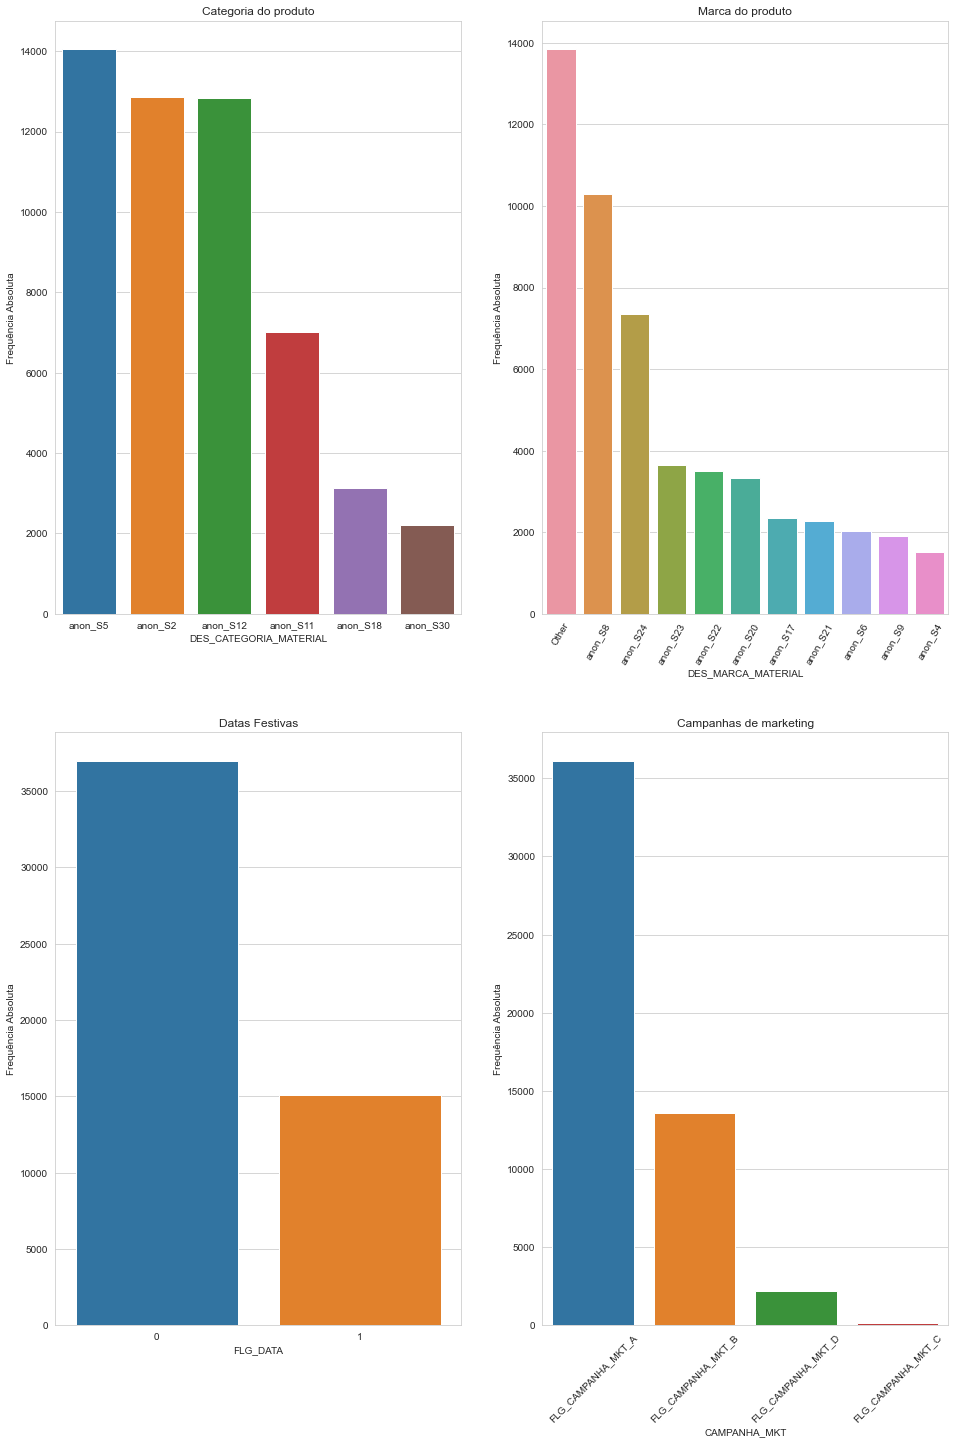

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(16, 24))
plot_distr('DES_CATEGORIA_MATERIAL', 0, 0, 'Categoria do produto', 0, df)
plot_distr('DES_MARCA_MATERIAL', 0, 1, 'Marca do produto', 60, df)
plot_distr('FLG_DATA', 1, 0, 'Datas Festivas', 0, df)
plot_distr('CAMPANHA_MKT', 1, 1, 'Campanhas de marketing', 45, df_cat)

Vamos fazer agora uma análise bivariada para entender como variam preço e quantidade vendida.

<AxesSubplot:xlabel='QT_VENDA', ylabel='VL_PRECO'>

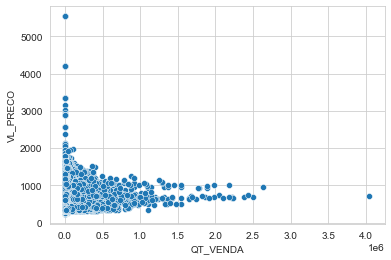

In [18]:
sns.scatterplot(data=df, x='QT_VENDA', y='VL_PRECO')

Vemos que parece não haver uma correlação significativa entre essas variáveis. Agora, vamos avaliar o comportamento temporal da quantidade de vendas.

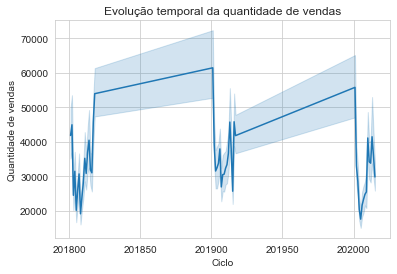

In [19]:
f = sns.lineplot(data= df, x='COD_CICLO', y='QT_VENDA')
f.set(title = 'Evolução temporal da quantidade de vendas', xlabel = 'Ciclo', ylabel = 'Quantidade de vendas')
plt.show()

Vamos checar se esta série temporal é estacionária, como aparenta ser, após tratamento dos dados faltantes. Utilizaremos para tanto o teste ADF (Augmented Dickey-Fuller). Por hora vamos checar como a série se comporta em ciclos com dias festivos versus ciclos sem dias festivos.

In [20]:
df_festa = df[df['FLG_DATA']==1]
df_festa.head()

,COD_MATERIAL,COD_CICLO,DES_CATEGORIA_MATERIAL,DES_MARCA_MATERIAL,FLG_DATA,FLG_CAMPANHA_MKT_A,FLG_CAMPANHA_MKT_B,FLG_CAMPANHA_MKT_C,FLG_CAMPANHA_MKT_D,FLG_CAMPANHA_MKT_E,FLG_CAMPANHA_MKT_F,PCT_DESCONTO,VL_PRECO,QT_VENDA
0,6246,201908,anon_S12,Other,1,0.0,0.0,0.0,0.0,0.0,0.0,NaN,461.40,240.0
2,6306,201916,anon_S12,Other,1,0.0,0.0,0.0,0.0,0.0,0.0,NaN,521.40,240.0
9,6480,201807,anon_S12,anon_S17,1,0.0,0.0,0.0,0.0,0.0,0.0,NaN,798.18,678.0
11,6480,201809,anon_S12,anon_S17,1,0.0,0.0,0.0,0.0,0.0,0.0,NaN,833.40,498.0
16,6528,201908,anon_S12,Other,1,0.0,0.0,0.0,0.0,0.0,0.0,NaN,403.50,240.0


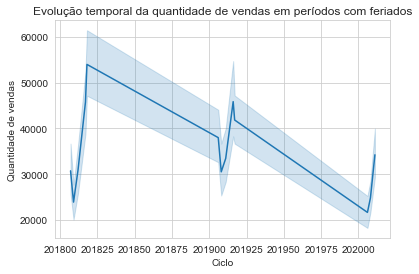

In [21]:
f = sns.lineplot(data= df_festa, x='COD_CICLO', y='QT_VENDA')
f.set(title = 'Evolução temporal da quantidade de vendas em períodos com feriados', xlabel = 'Ciclo', ylabel = 'Quantidade de vendas')
plt.show()

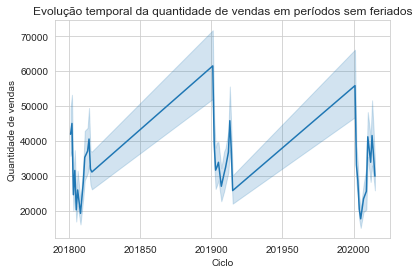

In [22]:
df_normal = df[df['FLG_DATA']!=1]
f = sns.lineplot(data= df_normal, x='COD_CICLO', y='QT_VENDA')
f.set(title = 'Evolução temporal da quantidade de vendas em períodos sem feriados', xlabel = 'Ciclo', ylabel = 'Quantidade de vendas')
plt.show()

Podemos notar comportamentos distintos em ambos os casos com relação a quantidade de vendas, o que pode induzir uma sazonalidade na série.

## Pré-processamento e engenharia de features

Primeiramente vamos eliminar a coluna 'PCT_DESCONTO' devido ao fato de possuir a maior parte de registros com valor faltante e a coluna 'COD_MATERIAL' por não trazer informação relevante para a análise.

In [23]:
df_no_missing = df.drop({'PCT_DESCONTO', 'COD_MATERIAL'}, axis=1)
df_no_missing.isna().sum()

COD_CICLO                    0
DES_CATEGORIA_MATERIAL       0
DES_MARCA_MATERIAL           0
FLG_DATA                     0
FLG_CAMPANHA_MKT_A           0
FLG_CAMPANHA_MKT_B           0
FLG_CAMPANHA_MKT_C           0
FLG_CAMPANHA_MKT_D           0
FLG_CAMPANHA_MKT_E           0
FLG_CAMPANHA_MKT_F           0
VL_PRECO                     6
QT_VENDA                  3148
dtype: int64

In [24]:
df_no_missing.dropna(inplace=True)
df_no_missing.isna().sum()

COD_CICLO                 0
DES_CATEGORIA_MATERIAL    0
DES_MARCA_MATERIAL        0
FLG_DATA                  0
FLG_CAMPANHA_MKT_A        0
FLG_CAMPANHA_MKT_B        0
FLG_CAMPANHA_MKT_C        0
FLG_CAMPANHA_MKT_D        0
FLG_CAMPANHA_MKT_E        0
FLG_CAMPANHA_MKT_F        0
VL_PRECO                  0
QT_VENDA                  0
dtype: int64

In [25]:
len(df_no_missing)

48940

In [26]:
df_no_missing.set_index('COD_CICLO', inplace=True)
df_no_missing.sort_index(inplace=True)

In [27]:
from statsmodels.tsa.stattools import adfuller
est = adfuller(df_no_missing['QT_VENDA'])

In [28]:
print('ADF Statistic:', est[0])
print('p-value:', est[1])

ADF Statistic: -24.556136170336043
p-value: 0.0


Como o p-value é nulo, podemos assumir que a série é estacionária. Vamos agora retirar os ciclos 202016, 202017 e 202101, que são os ciclos para os quais queremos prever a quantidade de vendas. Depois disso vamos aplicar o one-hot-encoding para as variáveis categóricas 'DES_CATEGORIA_MATERIAL' e 'DES_MARCA_MATERIAL'.

In [29]:
msk = (df_no_missing.index < 202010)
df_train = df_no_missing[msk].copy()
df_test = df_no_missing[~msk].copy()
df_test.shape

(6089, 11)

In [30]:
df_train.index.sort_values().unique()

Int64Index([201801, 201802, 201803, 201804, 201805, 201806, 201807, 201808,
            201809, 201810, 201811, 201812, 201813, 201814, 201815, 201816,
            201817, 201818, 201901, 201902, 201903, 201904, 201905, 201906,
            201907, 201908, 201909, 201910, 201911, 201912, 201913, 201914,
            201915, 201916, 201917, 202001, 202002, 202003, 202004, 202005,
            202006, 202007, 202008, 202009],
           dtype='int64', name='COD_CICLO')

In [31]:
df_train.index.nunique()

44

## Modelagem preditiva: ARIMA vs XGBoost



In [32]:
series = df_train.loc[:, 'QT_VENDA']
series

COD_CICLO
201801    355218.0
201801      1140.0
201801       480.0
201801     50142.0
201801     85554.0
            ...   
202009    119214.0
202009     11490.0
202009       486.0
202009      1866.0
202009      1068.0
Name: QT_VENDA, Length: 42851, dtype: float64

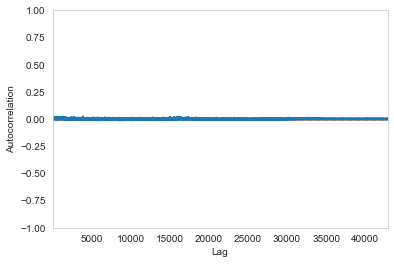

In [33]:
autocorrelation_plot(series)
plt.show()

Pelo gráfico acima percebemos que praticamente não há auto-correlação, indidicando que o parâmetro p, ou a componente AR do método, pode ser colocada como nula.

/Users/grasiele/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


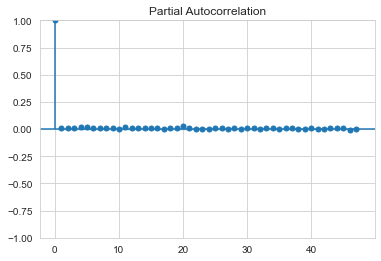

In [34]:
pacf_original = plot_pacf(series)

### Experimento 1

In [35]:
# usanto auto-arima para a escolha dos parâmetros de ordem
import pmdarima as pm
auto_arima = pm.auto_arima(series, seasonal=True)
auto_arima

ARIMA(order=(5, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [36]:
#model = sm.tsa.SARIMAX(series, order=(5, 1, 0), seasonal_order=(0, 0, 0, 34))
model = ARIMA(series, order=(5,1,0))

/Users/grasiele/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/grasiele/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/grasiele/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [37]:
results = model.fit()

In [38]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               QT_VENDA   No. Observations:                42851
Model:                 ARIMA(5, 1, 0)   Log Likelihood             -555600.080
Date:                Wed, 05 Apr 2023   AIC                        1111212.161
Time:                        17:08:33   BIC                        1111264.153
Sample:                             0   HQIC                       1111228.565
                              - 42851                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8377      0.002   -370.880      0.000      -0.842      -0.833
ar.L2         -0.6739      0.003   -233.824      0.000      -0.680      -0.668
ar.L3         -0.5066      0.003   -166.942      0.000      -0.513      -0.501
ar.L4         -0.3343      0.003   -116.859      0.000      -0.340      -0.329
ar.L5         -0.1619      0.002    -71.262      0.000      -0.166      -0.157
sigma2      1.071e+10   1.18e-14   9.06e+23      0.000    1.07e+10    1.07e+10
===================================================================================
Ljung-Box (L1) (Q):                  23.05   Jarque-Bera (JB):          19741072.40
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.12   Skew:                             7.26
Prob(H) (two-sided):                  0.00   Kurtosis:                       107.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.37e+39. Standard errors may be unstable.
"""

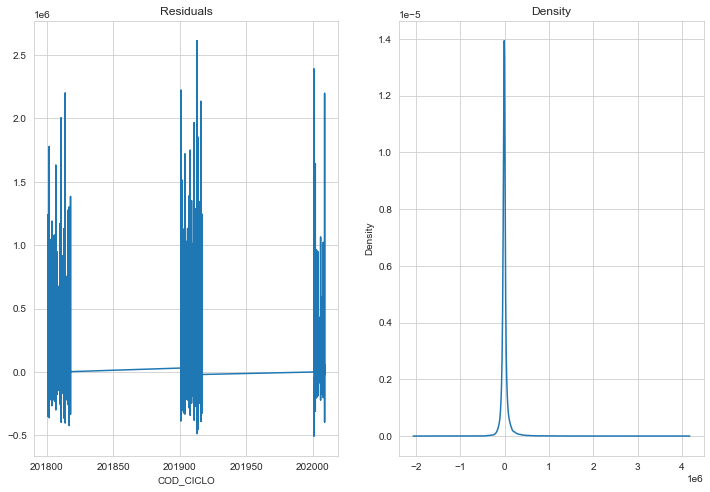

In [39]:
residuals = results.resid[1:]
fig, ax = plt.subplots(1,2, figsize=(12,8))
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

In [40]:
print(residuals.describe())

count    4.285000e+04
mean    -1.235019e+01
std      1.034910e+05
min     -5.060657e+05
25%     -2.849348e+04
50%     -1.017727e+04
75%      6.644992e+03
max      2.613855e+06
dtype: float64


### Avaliação do modelo

In [41]:
#ground-truth
series_test = df_test.loc[:, 'QT_VENDA']
series_test

COD_CICLO
202010    127662.0
202010      1632.0
202010    211644.0
202010     30330.0
202010     24072.0
            ...   
202015       240.0
202015    166968.0
202015     88980.0
202015      2568.0
202015     13314.0
Name: QT_VENDA, Length: 6089, dtype: float64

In [42]:
#predicted values
forecast = results.forecast(len(series_test))
forecast

/Users/grasiele/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


42851    23212.287948
42852    25614.980080
42853    10404.063398
42854    10351.568834
42855    12155.403136
             ...     
48935    13871.009692
48936    13871.009692
48937    13871.009692
48938    13871.009692
48939    13871.009692
Name: predicted_mean, Length: 6089, dtype: float64

In [43]:
df_no_missing['forecast'] = [None]*len(series) + forecast.tolist()
df_no_missing.head()

,DES_CATEGORIA_MATERIAL,DES_MARCA_MATERIAL,FLG_DATA,FLG_CAMPANHA_MKT_A,FLG_CAMPANHA_MKT_B,FLG_CAMPANHA_MKT_C,FLG_CAMPANHA_MKT_D,FLG_CAMPANHA_MKT_E,FLG_CAMPANHA_MKT_F,VL_PRECO,QT_VENDA,forecast
COD_CICLO,,,,,,,,,,,,
201801,anon_S12,anon_S9,0,0.0,1.0,0.5,0.0,0.0,0.0,773.625,355218.0,NaN
201801,anon_S18,Other,0,0.0,0.0,0.0,0.0,0.0,0.0,461.400,1140.0,NaN
201801,anon_S5,anon_S23,0,0.0,0.0,0.0,0.0,0.0,0.0,413.400,480.0,NaN
201801,anon_S5,Other,0,0.0,1.0,0.0,0.0,0.0,0.0,365.400,50142.0,NaN
201801,anon_S12,anon_S20,0,0.0,1.0,0.0,0.0,0.0,0.0,1073.400,85554.0,NaN


<AxesSubplot:xlabel='COD_CICLO', ylabel='QT_VENDA'>

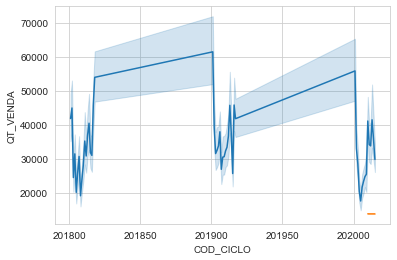

In [44]:
sns.lineplot(data=df_no_missing, x=df_no_missing.index, y='QT_VENDA')
sns.lineplot(data=df_no_missing, x=df_no_missing.index, y='forecast')

In [45]:
pred_ci = results.conf_int()
pred_ci

,0,1
ar.L1,-8.421551e-01,-8.333009e-01
ar.L2,-6.795149e-01,-6.682179e-01
ar.L3,-5.125973e-01,-5.007008e-01
ar.L4,-3.398738e-01,-3.286611e-01
ar.L5,-1.663168e-01,-1.574130e-01
sigma2,1.071026e+10,1.071026e+10


In [46]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

mae = mean_absolute_error(series_test, forecast)
mape = mean_absolute_percentage_error(series_test, forecast)
rmse = np.sqrt(mean_squared_error(series_test, forecast))

print(f'mae: {mae}')
print(f'mape: {mape}')
print(f'rmse: {rmse}')

mae: 34119.698878151
mape: 9.686110268735398
rmse: 111541.67218381405


Como vemos acima, o modelo não descreve bem nossos dados. Sendo assim, vamos tentar uma nova abordagem, onde vamos treinar um novo modelo para cada ciclo, e depois pegamos a média do forecast de cada ciclo para compor o forecast de novos ciclos.

### Experimento 2

In [47]:
groups = series.groupby(series.index)
test_groups = series_test.groupby(series_test.index)

In [48]:
import warnings
warnings.filterwarnings('ignore')

In [49]:
# Fit an ARIMA model for each group
models = {}
for name, group in groups:
    model = ARIMA(group, order=(2, 1, 0))
    results = model.fit()
    models[name] = results

In [50]:
forecast_group = {}
for key in models.keys():
        model = models[key]
        forecast = model.forecast(steps=len(group))
        forecast_group[key] = forecast
len(np.mean(list(forecast_group.values()), axis=0))

997

In [51]:
forecast_values = {}
forecast_group = {}
for name, group in test_groups:
    for key in models.keys():
        model = models[key]
        forecast = model.forecast(steps=len(group))
        forecast_group[key] = forecast
    forecast_values[name] = np.mean(list(forecast_group.values()), axis=0)

# Combine the forecasts for each cycle
forecasted_values = np.concatenate(list(forecast_values.values()))

# Print the length of forecasted values
print(len(forecasted_values))

6089


Test RMSE: 109318.5956096073
Test mae: 40935.842021123695


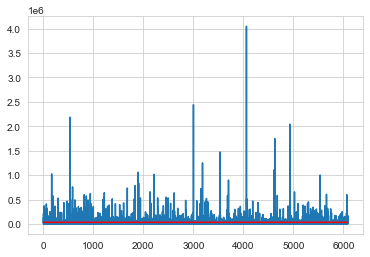

In [52]:
rmse = np.sqrt(mean_squared_error(series_test, forecasted_values))
mae = mean_absolute_error(series_test, forecasted_values)
print(f'Test RMSE: {rmse}')
print(f'Test mae: {mae}')
plt.plot(series_test.values)
plt.plot(forecasted_values, color='red')
plt.show()

### Experimento 3: XGBoost

In [53]:
df_no_missing.drop('forecast', axis=1, inplace=True)
df_xgb = df_no_missing.reset_index()
df_xgb.head()

,COD_CICLO,DES_CATEGORIA_MATERIAL,DES_MARCA_MATERIAL,FLG_DATA,FLG_CAMPANHA_MKT_A,FLG_CAMPANHA_MKT_B,FLG_CAMPANHA_MKT_C,FLG_CAMPANHA_MKT_D,FLG_CAMPANHA_MKT_E,FLG_CAMPANHA_MKT_F,VL_PRECO,QT_VENDA
0,201801,anon_S12,anon_S9,0,0.0,1.0,0.5,0.0,0.0,0.0,773.625,355218.0
1,201801,anon_S18,Other,0,0.0,0.0,0.0,0.0,0.0,0.0,461.400,1140.0
2,201801,anon_S5,anon_S23,0,0.0,0.0,0.0,0.0,0.0,0.0,413.400,480.0
3,201801,anon_S5,Other,0,0.0,1.0,0.0,0.0,0.0,0.0,365.400,50142.0
4,201801,anon_S12,anon_S20,0,0.0,1.0,0.0,0.0,0.0,0.0,1073.400,85554.0


In [54]:
# one-hot encoding categorical variables
#df_xgb = df_no_missing.copy()
df_xgb = pd.get_dummies(data=df_xgb, columns=['DES_CATEGORIA_MATERIAL','DES_MARCA_MATERIAL'], drop_first=True)
df_xgb.head()

,COD_CICLO,FLG_DATA,FLG_CAMPANHA_MKT_A,FLG_CAMPANHA_MKT_B,FLG_CAMPANHA_MKT_C,FLG_CAMPANHA_MKT_D,FLG_CAMPANHA_MKT_E,FLG_CAMPANHA_MKT_F,VL_PRECO,QT_VENDA,...,DES_MARCA_MATERIAL_anon_S17,DES_MARCA_MATERIAL_anon_S20,DES_MARCA_MATERIAL_anon_S21,DES_MARCA_MATERIAL_anon_S22,DES_MARCA_MATERIAL_anon_S23,DES_MARCA_MATERIAL_anon_S24,DES_MARCA_MATERIAL_anon_S4,DES_MARCA_MATERIAL_anon_S6,DES_MARCA_MATERIAL_anon_S8,DES_MARCA_MATERIAL_anon_S9
0,201801,0,0.0,1.0,0.5,0.0,0.0,0.0,773.625,355218.0,...,0,0,0,0,0,0,0,0,0,1
1,201801,0,0.0,0.0,0.0,0.0,0.0,0.0,461.400,1140.0,...,0,0,0,0,0,0,0,0,0,0
2,201801,0,0.0,0.0,0.0,0.0,0.0,0.0,413.400,480.0,...,0,0,0,0,1,0,0,0,0,0
3,201801,0,0.0,1.0,0.0,0.0,0.0,0.0,365.400,50142.0,...,0,0,0,0,0,0,0,0,0,0
4,201801,0,0.0,1.0,0.0,0.0,0.0,0.0,1073.400,85554.0,...,0,1,0,0,0,0,0,0,0,0


In [55]:
from sklearn.model_selection import train_test_split
features = df_xgb.drop(["QT_VENDA"], axis = 1)
target = df_xgb["QT_VENDA"]
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.20)

In [56]:
import xgboost as xgb

In [57]:
params = {'max_depth':8, "booster": "gbtree", 'eta':0.1, 'objective':'reg:squarederror'}
train = xgb.DMatrix(X_train, y_train)
test = xgb.DMatrix(X_test, y_test)
watchlist = [(train, 'train'), (test, 'eval')]
# Training the model
xgboost = xgb.train(params, train, 100, evals=watchlist, early_stopping_rounds= 50, verbose_eval=True)

[0]	train-rmse:99466.43750	eval-rmse:97640.06250
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 50 rounds.
[1]	train-rmse:95062.56250	eval-rmse:94255.45312
[2]	train-rmse:91310.67188	eval-rmse:91445.93750
[3]	train-rmse:88045.26562	eval-rmse:88901.93750
[4]	train-rmse:85184.29688	eval-rmse:87010.04688
[5]	train-rmse:82664.50781	eval-rmse:85318.59375
[6]	train-rmse:80325.32812	eval-rmse:83887.85156
[7]	train-rmse:78360.14844	eval-rmse:82529.18750
[8]	train-rmse:76596.54688	eval-rmse:81285.96875
[9]	train-rmse:75143.43750	eval-rmse:80390.28125
[10]	train-rmse:73423.03906	eval-rmse:79639.87500
[11]	train-rmse:72202.13281	eval-rmse:78914.08594
[12]	train-rmse:70902.91406	eval-rmse:78378.01562
[13]	train-rmse:69839.25781	eval-rmse:77800.99219
[14]	train-rmse:68829.67969	eval-rmse:77364.10156
[15]	train-rmse:67999.42188	eval-rmse:76928.75000
[16]	train-rmse:67255.49219	eval-rmse:76645.34375
[17]	train-rmse:6

In [59]:
# Making predictions
preds = xgboost.predict(test)

In [60]:
rms_xgboost = np.sqrt(mean_squared_error(y_test, preds))
print("Root Mean Squared Error for XGBoost:", rms_xgboost)
mae_xgboost = mean_absolute_error(y_test, preds)
print("Mean Absolute Error for XGBoost:", mae_xgboost)

Root Mean Squared Error for XGBoost: 73424.60653909661
Mean Absolute Error for XGBoost: 25316.42034626991


Vemos uma melhora significativa de performance com respeito aos nossos outros experimentos, com um rmse da ordem de 40% menor. Vamos então construir nosso modelo baseado nesse algoritmo.

## Execução dos scripts

In [2]:
%run preprocess.py

Started preprocess step at 18:11:31
Handling missing values
Encoding categorical variables
Train set with 39152 rows
Test set with 9788 rows
Dropping unecessary columns
Saving sets to csv
Finished Preprocess step at 18:11:33


In [3]:
%run train.py

/Users/grasiele/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/grasiele/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/Users/grasiele/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/Users/grasiele/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:367: Future

Started Train step at 18:11:39
Reading train and test sets
Training dataset
[0]	train-rmse:101904.10938	eval-rmse:85968.62500
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[1]	train-rmse:97382.64844	eval-rmse:82979.02344
[2]	train-rmse:93461.34375	eval-rmse:80507.48438
[3]	train-rmse:89886.90625	eval-rmse:78515.92969
[4]	train-rmse:86663.18750	eval-rmse:76802.09375
[5]	train-rmse:83912.90625	eval-rmse:75503.17188
[6]	train-rmse:81660.94531	eval-rmse:74349.27344
[7]	train-rmse:79685.21094	eval-rmse:73505.03906
[8]	train-rmse:77830.31250	eval-rmse:72764.61719
[9]	train-rmse:76252.28125	eval-rmse:72266.17188
[10]	train-rmse:74654.98438	eval-rmse:71525.00000
[11]	train-rmse:73308.53906	eval-rmse:70931.45312
[12]	train-rmse:72109.73438	eval-rmse:70561.73438
[13]	train-rmse:70787.66406	eval-rmse:70239.89844
[14]	train-rmse:69805.23438	eval-rmse:69994.92969
[15]	train-rmse:68992.32812	eval-rmse:69

In [9]:
features = ['FLG_CAMPANHA_MKT_B', 'FLG_CAMPANHA_MKT_D', 'VL_PRECO', 'FLG_DATA', 'DES_MARCA_MATERIAL_anon_S24', 
            'DES_MARCA_MATERIAL_anon_S20', 'FLG_CAMPANHA_MKT_C', 'DES_CATEGORIA_MATERIAL_anon_S30', 
            'DES_CATEGORIA_MATERIAL_anon_S12', 'COD_CICLO', 'DES_CATEGORIA_MATERIAL_anon_S2', 'FLG_CAMPANHA_MKT_A', 
            'DES_MARCA_MATERIAL_anon_S34', 'DES_CATEGORIA_MATERIAL_anon_S5', 'DES_MARCA_MATERIAL_anon_S22', 
            'DES_MARCA_MATERIAL_anon_S25', 'DES_MARCA_MATERIAL_anon_S28', 'DES_MARCA_MATERIAL_anon_S21', 
            'DES_MARCA_MATERIAL_anon_S4', 'DES_MARCA_MATERIAL_anon_S33', 'DES_MARCA_MATERIAL_anon_S8', 
            'DES_MARCA_MATERIAL_anon_S14', 'DES_MARCA_MATERIAL_anon_S47', 'DES_MARCA_MATERIAL_anon_S17', 
            'DES_MARCA_MATERIAL_anon_S19', 'DES_MARCA_MATERIAL_anon_S3', 'DES_MARCA_MATERIAL_anon_S6', 
            'DES_MARCA_MATERIAL_anon_S26', 'DES_MARCA_MATERIAL_anon_S31', 'DES_MARCA_MATERIAL_anon_S32', 
            'DES_CATEGORIA_MATERIAL_anon_S18', 'DES_MARCA_MATERIAL_anon_S50', 'DES_MARCA_MATERIAL_anon_S15', 
            'DES_MARCA_MATERIAL_anon_S46', 'DES_MARCA_MATERIAL_anon_S23', 'DES_MARCA_MATERIAL_anon_S39', 'DES_MARCA_MATERIAL_anon_S9',
            'DES_MARCA_MATERIAL_anon_S35', 'DES_MARCA_MATERIAL_anon_S29', 'DES_MARCA_MATERIAL_anon_S42', 
            'DES_MARCA_MATERIAL_anon_S40', 'DES_MARCA_MATERIAL_anon_S41', 'DES_MARCA_MATERIAL_anon_S45']

In [1]:
import pandas as pd
df = pd.read_csv('output.csv')
new_data = df[df['COD_CICLO'].isin([202016, 202017, 202101])]
new_data.head()

/Users/grasiele/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


,COD_MATERIAL,COD_CICLO,DES_CATEGORIA_MATERIAL,DES_MARCA_MATERIAL,FLG_DATA,FLG_CAMPANHA_MKT_A,FLG_CAMPANHA_MKT_B,FLG_CAMPANHA_MKT_C,FLG_CAMPANHA_MKT_D,FLG_CAMPANHA_MKT_E,FLG_CAMPANHA_MKT_F,PCT_DESCONTO,VL_PRECO,QT_VENDA
29,7098,202101,anon_S12,anon_S45,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,791.4,NaN
47,7230,202016,anon_S12,anon_S42,1,0.0,0.0,0.0,0.0,0.0,0.0,NaN,863.4,NaN
48,7230,202101,anon_S12,anon_S42,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,863.4,NaN
113,10104,202016,anon_S12,anon_S47,1,0.0,0.0,0.0,0.0,0.0,0.0,NaN,809.4,NaN
114,10104,202017,anon_S12,anon_S47,1,0.0,0.0,0.0,0.0,0.0,0.0,NaN,809.4,NaN


In [6]:
from inference import predict_xgb

In [7]:
predict_xgb(new_data, features)

/Users/grasiele/Dropbox/Mac/Documents/case-study-forecasting/inference.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns={'PCT_DESCONTO', 'COD_MATERIAL', 'QT_VENDA'}, inplace=True)
/Users/grasiele/Dropbox/Mac/Documents/case-study-forecasting/inference.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


Adding empty feature: DES_MARCA_MATERIAL_anon_S40
Adding empty feature: DES_MARCA_MATERIAL_anon_S41
Removing extra feature not in feature list: FLG_CAMPANHA_MKT_E
Removing extra feature not in feature list: FLG_CAMPANHA_MKT_F
Removing extra feature not in feature list: DES_MARCA_MATERIAL_anon_S16
Removing extra feature not in feature list: DES_MARCA_MATERIAL_anon_S27
Removing extra feature not in feature list: DES_MARCA_MATERIAL_anon_S37
Removing extra feature not in feature list: DES_MARCA_MATERIAL_anon_S38
Removing extra feature not in feature list: DES_MARCA_MATERIAL_anon_S43
Removing extra feature not in feature list: DES_MARCA_MATERIAL_anon_S44
Removing extra feature not in feature list: DES_MARCA_MATERIAL_anon_S48
Removing extra feature not in feature list: DES_MARCA_MATERIAL_anon_S49
Removing extra feature not in feature list: DES_MARCA_MATERIAL_anon_S51
Removing extra feature not in feature list: DES_MARCA_MATERIAL_anon_S53
Removing extra feature not in feature list: DES_MARCA_

ValueError: feature_names mismatch: ['COD_CICLO', 'FLG_DATA', 'FLG_CAMPANHA_MKT_A', 'FLG_CAMPANHA_MKT_B', 'FLG_CAMPANHA_MKT_C', 'FLG_CAMPANHA_MKT_D', 'FLG_CAMPANHA_MKT_E', 'FLG_CAMPANHA_MKT_F', 'VL_PRECO', 'DES_CATEGORIA_MATERIAL_anon_S12', 'DES_CATEGORIA_MATERIAL_anon_S18', 'DES_CATEGORIA_MATERIAL_anon_S2', 'DES_CATEGORIA_MATERIAL_anon_S30', 'DES_CATEGORIA_MATERIAL_anon_S5', 'DES_MARCA_MATERIAL_anon_S14', 'DES_MARCA_MATERIAL_anon_S15', 'DES_MARCA_MATERIAL_anon_S16', 'DES_MARCA_MATERIAL_anon_S17', 'DES_MARCA_MATERIAL_anon_S19', 'DES_MARCA_MATERIAL_anon_S20', 'DES_MARCA_MATERIAL_anon_S21', 'DES_MARCA_MATERIAL_anon_S22', 'DES_MARCA_MATERIAL_anon_S23', 'DES_MARCA_MATERIAL_anon_S24', 'DES_MARCA_MATERIAL_anon_S25', 'DES_MARCA_MATERIAL_anon_S26', 'DES_MARCA_MATERIAL_anon_S27', 'DES_MARCA_MATERIAL_anon_S28', 'DES_MARCA_MATERIAL_anon_S29', 'DES_MARCA_MATERIAL_anon_S3', 'DES_MARCA_MATERIAL_anon_S31', 'DES_MARCA_MATERIAL_anon_S32', 'DES_MARCA_MATERIAL_anon_S33', 'DES_MARCA_MATERIAL_anon_S34', 'DES_MARCA_MATERIAL_anon_S35', 'DES_MARCA_MATERIAL_anon_S36', 'DES_MARCA_MATERIAL_anon_S37', 'DES_MARCA_MATERIAL_anon_S38', 'DES_MARCA_MATERIAL_anon_S39', 'DES_MARCA_MATERIAL_anon_S4', 'DES_MARCA_MATERIAL_anon_S40', 'DES_MARCA_MATERIAL_anon_S41', 'DES_MARCA_MATERIAL_anon_S42', 'DES_MARCA_MATERIAL_anon_S43', 'DES_MARCA_MATERIAL_anon_S44', 'DES_MARCA_MATERIAL_anon_S45', 'DES_MARCA_MATERIAL_anon_S46', 'DES_MARCA_MATERIAL_anon_S47', 'DES_MARCA_MATERIAL_anon_S48', 'DES_MARCA_MATERIAL_anon_S49', 'DES_MARCA_MATERIAL_anon_S50', 'DES_MARCA_MATERIAL_anon_S51', 'DES_MARCA_MATERIAL_anon_S52', 'DES_MARCA_MATERIAL_anon_S53', 'DES_MARCA_MATERIAL_anon_S54', 'DES_MARCA_MATERIAL_anon_S55', 'DES_MARCA_MATERIAL_anon_S56', 'DES_MARCA_MATERIAL_anon_S57', 'DES_MARCA_MATERIAL_anon_S58', 'DES_MARCA_MATERIAL_anon_S59', 'DES_MARCA_MATERIAL_anon_S6', 'DES_MARCA_MATERIAL_anon_S60', 'DES_MARCA_MATERIAL_anon_S61', 'DES_MARCA_MATERIAL_anon_S62', 'DES_MARCA_MATERIAL_anon_S63', 'DES_MARCA_MATERIAL_anon_S64', 'DES_MARCA_MATERIAL_anon_S65', 'DES_MARCA_MATERIAL_anon_S66', 'DES_MARCA_MATERIAL_anon_S67', 'DES_MARCA_MATERIAL_anon_S68', 'DES_MARCA_MATERIAL_anon_S69', 'DES_MARCA_MATERIAL_anon_S70', 'DES_MARCA_MATERIAL_anon_S71', 'DES_MARCA_MATERIAL_anon_S72', 'DES_MARCA_MATERIAL_anon_S73', 'DES_MARCA_MATERIAL_anon_S74', 'DES_MARCA_MATERIAL_anon_S75', 'DES_MARCA_MATERIAL_anon_S76', 'DES_MARCA_MATERIAL_anon_S77', 'DES_MARCA_MATERIAL_anon_S78', 'DES_MARCA_MATERIAL_anon_S79', 'DES_MARCA_MATERIAL_anon_S8', 'DES_MARCA_MATERIAL_anon_S82', 'DES_MARCA_MATERIAL_anon_S83', 'DES_MARCA_MATERIAL_anon_S84', 'DES_MARCA_MATERIAL_anon_S85', 'DES_MARCA_MATERIAL_anon_S86', 'DES_MARCA_MATERIAL_anon_S87', 'DES_MARCA_MATERIAL_anon_S89', 'DES_MARCA_MATERIAL_anon_S9', 'DES_MARCA_MATERIAL_anon_S90', 'DES_MARCA_MATERIAL_anon_S91', 'DES_MARCA_MATERIAL_anon_S92', 'DES_MARCA_MATERIAL_anon_S93', 'DES_MARCA_MATERIAL_anon_S94'] ['COD_CICLO', 'FLG_DATA', 'FLG_CAMPANHA_MKT_A', 'FLG_CAMPANHA_MKT_B', 'FLG_CAMPANHA_MKT_C', 'FLG_CAMPANHA_MKT_D', 'VL_PRECO', 'DES_CATEGORIA_MATERIAL_anon_S12', 'DES_CATEGORIA_MATERIAL_anon_S18', 'DES_CATEGORIA_MATERIAL_anon_S2', 'DES_CATEGORIA_MATERIAL_anon_S30', 'DES_CATEGORIA_MATERIAL_anon_S5', 'DES_MARCA_MATERIAL_anon_S14', 'DES_MARCA_MATERIAL_anon_S15', 'DES_MARCA_MATERIAL_anon_S17', 'DES_MARCA_MATERIAL_anon_S19', 'DES_MARCA_MATERIAL_anon_S20', 'DES_MARCA_MATERIAL_anon_S21', 'DES_MARCA_MATERIAL_anon_S22', 'DES_MARCA_MATERIAL_anon_S23', 'DES_MARCA_MATERIAL_anon_S24', 'DES_MARCA_MATERIAL_anon_S25', 'DES_MARCA_MATERIAL_anon_S26', 'DES_MARCA_MATERIAL_anon_S28', 'DES_MARCA_MATERIAL_anon_S29', 'DES_MARCA_MATERIAL_anon_S3', 'DES_MARCA_MATERIAL_anon_S31', 'DES_MARCA_MATERIAL_anon_S32', 'DES_MARCA_MATERIAL_anon_S33', 'DES_MARCA_MATERIAL_anon_S34', 'DES_MARCA_MATERIAL_anon_S35', 'DES_MARCA_MATERIAL_anon_S39', 'DES_MARCA_MATERIAL_anon_S4', 'DES_MARCA_MATERIAL_anon_S42', 'DES_MARCA_MATERIAL_anon_S45', 'DES_MARCA_MATERIAL_anon_S46', 'DES_MARCA_MATERIAL_anon_S47', 'DES_MARCA_MATERIAL_anon_S50', 'DES_MARCA_MATERIAL_anon_S6', 'DES_MARCA_MATERIAL_anon_S8', 'DES_MARCA_MATERIAL_anon_S9', 'DES_MARCA_MATERIAL_anon_S40', 'DES_MARCA_MATERIAL_anon_S41']
expected DES_MARCA_MATERIAL_anon_S54, DES_MARCA_MATERIAL_anon_S48, DES_MARCA_MATERIAL_anon_S27, DES_MARCA_MATERIAL_anon_S73, DES_MARCA_MATERIAL_anon_S85, FLG_CAMPANHA_MKT_F, DES_MARCA_MATERIAL_anon_S38, DES_MARCA_MATERIAL_anon_S78, DES_MARCA_MATERIAL_anon_S36, DES_MARCA_MATERIAL_anon_S59, DES_MARCA_MATERIAL_anon_S63, DES_MARCA_MATERIAL_anon_S67, FLG_CAMPANHA_MKT_E, DES_MARCA_MATERIAL_anon_S52, DES_MARCA_MATERIAL_anon_S43, DES_MARCA_MATERIAL_anon_S75, DES_MARCA_MATERIAL_anon_S62, DES_MARCA_MATERIAL_anon_S76, DES_MARCA_MATERIAL_anon_S86, DES_MARCA_MATERIAL_anon_S87, DES_MARCA_MATERIAL_anon_S49, DES_MARCA_MATERIAL_anon_S82, DES_MARCA_MATERIAL_anon_S74, DES_MARCA_MATERIAL_anon_S61, DES_MARCA_MATERIAL_anon_S64, DES_MARCA_MATERIAL_anon_S84, DES_MARCA_MATERIAL_anon_S65, DES_MARCA_MATERIAL_anon_S89, DES_MARCA_MATERIAL_anon_S56, DES_MARCA_MATERIAL_anon_S60, DES_MARCA_MATERIAL_anon_S58, DES_MARCA_MATERIAL_anon_S93, DES_MARCA_MATERIAL_anon_S71, DES_MARCA_MATERIAL_anon_S94, DES_MARCA_MATERIAL_anon_S79, DES_MARCA_MATERIAL_anon_S55, DES_MARCA_MATERIAL_anon_S91, DES_MARCA_MATERIAL_anon_S83, DES_MARCA_MATERIAL_anon_S57, DES_MARCA_MATERIAL_anon_S70, DES_MARCA_MATERIAL_anon_S66, DES_MARCA_MATERIAL_anon_S92, DES_MARCA_MATERIAL_anon_S90, DES_MARCA_MATERIAL_anon_S51, DES_MARCA_MATERIAL_anon_S68, DES_MARCA_MATERIAL_anon_S53, DES_MARCA_MATERIAL_anon_S77, DES_MARCA_MATERIAL_anon_S69, DES_MARCA_MATERIAL_anon_S44, DES_MARCA_MATERIAL_anon_S37, DES_MARCA_MATERIAL_anon_S16, DES_MARCA_MATERIAL_anon_S72 in input data